# 0. Imports and Functions

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import CubicSpline,  interp1d
from geopy.distance import geodesic

from joblib import Parallel, delayed

In [2]:
# Predefined seeds
seeds = [1415, 9265, 3589, 7932, 3846, 2643, 3832, 7950, 2884, 1971]

seed_index = 9  # Change this value (0, 1, 2,..., 9) for different seeds

current_seed = seeds[seed_index]

np.random.seed(current_seed)
random.seed(current_seed)         
os.environ['PYTHONHASHSEED'] = str(current_seed)

print(f"Using Seed {seed_index}: {current_seed}")

Using Seed 9: 1971


In [3]:
def summarize_dataframe(df):
    display(df)
    
    unique_vessel_groups = df['VesselGroup'].unique()
    num_vessel_groups = df['VesselGroup'].nunique()
    
    num_rows = f"{len(df):,}"
    
    print(f"The dataframe contains {num_rows} rows.")
    print()
    print(f"There are {num_vessel_groups} unique vessel groups.")
    print(f"The unique vessel groups are: {unique_vessel_groups}")
    
    print("\nRow counts for each vessel group:")
    for group in unique_vessel_groups:
        group_count = len(df[df['VesselGroup'] == group])
        print(f"Group {group}: {group_count:,} rows")

# 1. Read Datasets and Mapping

### Read

In [4]:
# https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2023/index.html

df1 = pd.read_csv('/Users/fabian/Downloads/MasterDegree/Raw/AIS_2023_01_01.csv')
df2 = pd.read_csv('/Users/fabian/Downloads/MasterDegree/Raw/AIS_2023_05_05.csv')
df3 = pd.read_csv('/Users/fabian/Downloads/MasterDegree/Raw/AIS_2023_08_04.csv')
df4 = pd.read_csv('/Users/fabian/Downloads/MasterDegree/Raw/AIS_2023_09_23.csv')
df5 = pd.read_csv('/Users/fabian/Downloads/MasterDegree/Raw/AIS_2023_12_14.csv')

In [5]:
df_combined = pd.concat([df1, df2, df3, df4, df5])

In [6]:
display(df_combined)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
0,368926035,2023-01-01T00:00:05,38.65165,-90.17964,0.1,360.0,511.0,KIMMSWICK,NaN,AENA,33.0,15.0,NaN,NaN,NaN,33.0,A
1,367647050,2023-01-01T00:00:04,30.16506,-90.99936,6.3,161.4,511.0,USS CAIRO,NaN,WDH7325,31.0,0.0,20.0,NaN,NaN,31.0,A
2,352001704,2023-01-01T00:00:04,28.91963,-94.37033,14.7,97.5,97.0,ENEOS EXPLORER,IMO9935492,3E2723,80.0,0.0,230.0,36.0,11.7,80.0,A
3,367104060,2023-01-01T00:00:00,34.33537,-119.56046,14.8,202.9,511.0,ALAN T,IMO8982577,WDC9571,60.0,15.0,28.0,7.0,NaN,0.0,A
4,367099730,2023-01-01T00:00:02,26.53889,-97.40485,0.0,360.0,511.0,JESSIE M,NaN,WDJ2892,52.0,0.0,0.0,0.0,0.0,52.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7564777,303327000,2023-12-14T23:48:58,13.43209,144.66080,0.1,0.0,34.0,OCEAN VICTORY,IMO7121140,WDG8218,90.0,5.0,66.0,17.0,4.0,35.0,A
7564778,303327000,2023-12-14T23:57:56,13.43211,144.66079,0.1,0.0,34.0,OCEAN VICTORY,IMO7121140,WDG8218,90.0,5.0,66.0,17.0,4.0,35.0,A
7564779,367796190,2023-12-14T23:30:20,13.46124,144.66422,0.0,360.0,511.0,AGILITY,IMO9320984,WDJ6282,31.0,11.0,NaN,NaN,NaN,52.0,A
7564780,367796190,2023-12-14T23:42:50,13.46124,144.66423,0.0,360.0,511.0,AGILITY,IMO9320984,WDJ6282,31.0,11.0,NaN,NaN,NaN,52.0,A


### Mapping

In [7]:
unique_vesseltype_numbers = df_combined['VesselType'].unique()
print (unique_vesseltype_numbers)

[ 33.  31.  80.  60.  52.  89.  37.  57.  90.  36.  70.  30.  97.  34.
  40.  38.  50.  99.  51.  32.  81.  69.  71.  55.   0.  79.  95.  65.
  53.  35.  56.  72.  84.  74.  64.  20.  73.  82.  54.  98. 136.  16.
   1.  61.  39.  49.  66.  75.   7.  25.  83.  76.   3.  nan  10.  23.
  59.  19.   9.  78.  58.  67.  91.  68.  24.  96.  47. 200.  92.   6.
  29.  88.   4.  26.]


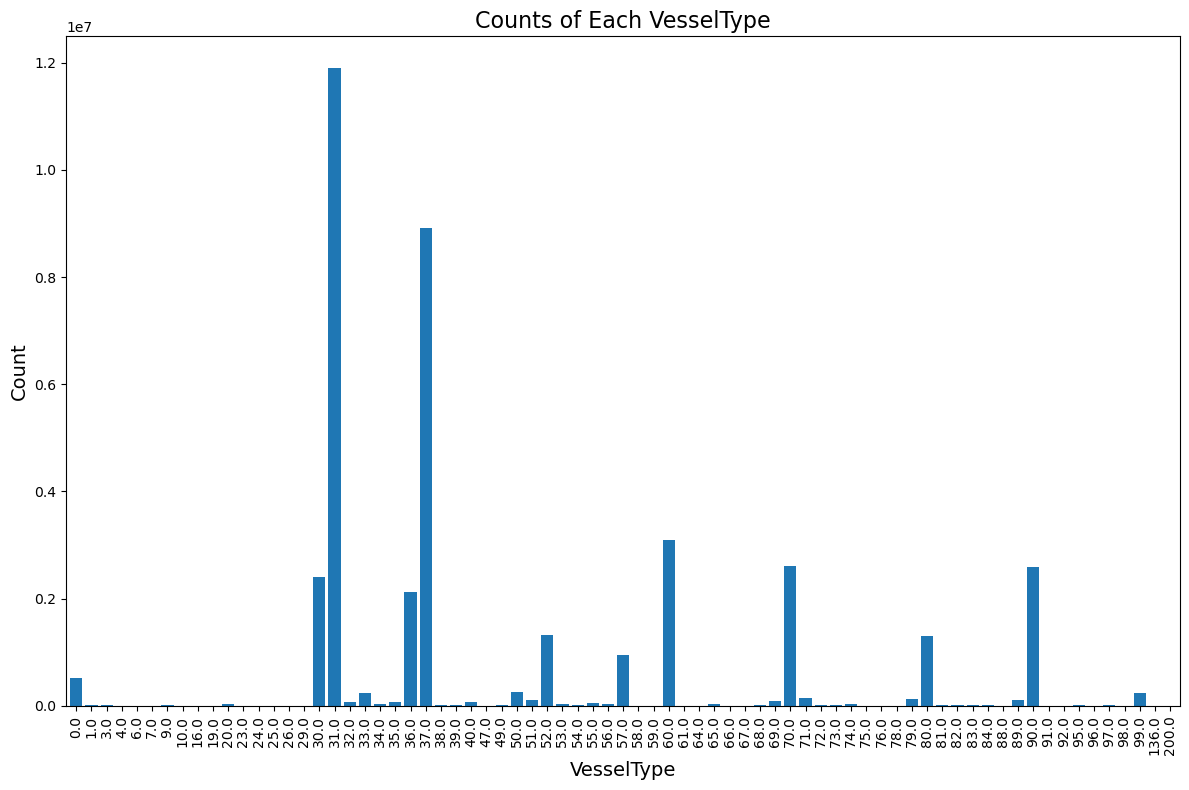

In [8]:
vesseltype_counts = df_combined['VesselType'].value_counts()

plt.figure(figsize=(12, 8))
vesseltype_counts.sort_index().plot(kind='bar', width=0.8)

plt.title('Counts of Each VesselType', fontsize=16)
plt.xlabel('VesselType', fontsize=14)
plt.ylabel('Count', fontsize=14)

tick_positions = np.arange(len(vesseltype_counts.sort_index()))
plt.xticks(tick_positions, vesseltype_counts.sort_index().index, rotation=90, fontsize=10)

plt.tight_layout()
plt.show()

In [9]:
#https://coast.noaa.gov/data/marinecadastre/ais/VesselTypeCodes2018.pdf
#https://api.vtexplorer.com/docs/ref-aistypes.html

vessel_type_mapping = {
    30: 'Fishing', 31: 'Towing', 36: 'Sailing', 37: 'Pleasure Craft', 52: 'Tug', 60: 'Passenger', 70: 'Cargo', 80: 'Tanker'
}

In [10]:
df_combined['VesselGroup'] = df_combined['VesselType'].map(vessel_type_mapping)
df_combined = df_combined.dropna(subset=['VesselGroup'])

In [11]:
display(df_combined)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselGroup
1,367647050,2023-01-01T00:00:04,30.16506,-90.99936,6.3,161.4,511.0,USS CAIRO,NaN,WDH7325,31.0,0.0,20.0,NaN,NaN,31.0,A,Towing
2,352001704,2023-01-01T00:00:04,28.91963,-94.37033,14.7,97.5,97.0,ENEOS EXPLORER,IMO9935492,3E2723,80.0,0.0,230.0,36.0,11.7,80.0,A,Tanker
3,367104060,2023-01-01T00:00:00,34.33537,-119.56046,14.8,202.9,511.0,ALAN T,IMO8982577,WDC9571,60.0,15.0,28.0,7.0,NaN,0.0,A,Passenger
4,367099730,2023-01-01T00:00:02,26.53889,-97.40485,0.0,360.0,511.0,JESSIE M,NaN,WDJ2892,52.0,0.0,0.0,0.0,0.0,52.0,A,Tug
5,367579120,2023-01-01T00:00:03,29.32348,-94.78112,0.0,248.5,511.0,TERRY FONTENOT,NaN,WDG8590,31.0,0.0,16.0,7.0,NaN,52.0,A,Towing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7564747,367796190,2023-12-14T23:24:30,13.46123,144.66424,0.0,360.0,511.0,AGILITY,IMO9320984,WDJ6282,31.0,11.0,NaN,NaN,NaN,52.0,A,Towing
7564748,367796190,2023-12-14T23:28:00,13.46124,144.66424,0.0,360.0,511.0,AGILITY,IMO9320984,WDJ6282,31.0,11.0,NaN,NaN,NaN,52.0,A,Towing
7564779,367796190,2023-12-14T23:30:20,13.46124,144.66422,0.0,360.0,511.0,AGILITY,IMO9320984,WDJ6282,31.0,11.0,NaN,NaN,NaN,52.0,A,Towing
7564780,367796190,2023-12-14T23:42:50,13.46124,144.66423,0.0,360.0,511.0,AGILITY,IMO9320984,WDJ6282,31.0,11.0,NaN,NaN,NaN,52.0,A,Towing


# 2. Cleaning and Selecting

### Initail Cleaning

In [12]:
df_combined.drop(columns=['Heading', 'IMO', 'CallSign', 'Status','VesselType','Length', 'Width', 'Draft', 'Cargo', 'TransceiverClass'], inplace=True)

In [13]:
df_init_cleaned = df_combined.sort_values(by=['MMSI', 'BaseDateTime']).reset_index(drop=True)

### Selecting

In [14]:
group1 = 'Tug'
group2 = 'Passenger'
group3 = 'Tanker'

selected_classes = [group1, group2, group3]

In [15]:
df_selected = df_init_cleaned[df_init_cleaned['VesselGroup'].isin(selected_classes)]

In [16]:
summarize_dataframe(df_selected)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,1,2023-01-01T00:01:36,49.12525,-123.08501,0.0,267.1,A,Passenger
1,1,2023-01-01T00:07:35,49.12526,-123.08501,0.0,75.7,A,Passenger
2,1,2023-01-01T00:10:35,49.12525,-123.08501,0.0,290.5,A,Passenger
3,1,2023-01-01T00:25:36,49.12525,-123.08501,0.0,264.1,A,Passenger
4,1,2023-01-01T00:28:36,49.12525,-123.08501,0.0,290.0,A,Passenger
...,...,...,...,...,...,...,...,...
33651083,987654321,2023-12-14T23:28:29,48.42098,-123.38656,0.0,174.6,ME AND THE BOYS,Passenger
33651084,987654321,2023-12-14T23:34:29,48.42098,-123.38656,0.0,224.9,ME AND THE BOYS,Passenger
33651085,987654321,2023-12-14T23:40:31,48.42098,-123.38656,0.0,196.9,ME AND THE BOYS,Passenger
33651086,987654321,2023-12-14T23:46:31,48.42098,-123.38656,0.0,83.4,ME AND THE BOYS,Passenger


The dataframe contains 5,713,066 rows.

There are 3 unique vessel groups.
The unique vessel groups are: ['Passenger' 'Tanker' 'Tug']

Row counts for each vessel group:
Group Passenger: 3,086,911 rows
Group Tanker: 1,299,219 rows
Group Tug: 1,326,936 rows


### Proper cleaning

In [17]:
# Filter out rows where SOG is 0 or less
df_cleaned = df_selected[(df_selected['SOG'] > 0) & (df_selected['SOG'] < 130)]

In [18]:
# Filter out rows where COG is outside the range of 0-360
df_cleaned = df_cleaned[(df_cleaned['COG'] >= 0) & (df_cleaned['COG'] <= 360)]

In [19]:
df_cleaned = df_cleaned[df_cleaned['MMSI'].astype(str).str.len() == 9]

In [20]:
# Drop rows where any of the specified columns have NaN values --> MMSI will be dropped
columns_to_check = ['MMSI', 'BaseDateTime', 'SOG', 'COG', 'LAT', 'LON', 'VesselName', 'VesselGroup']
mmsi_with_nan = df_cleaned[df_cleaned[columns_to_check].isna().any(axis=1)]['MMSI'].unique()
df_cleaned = df_cleaned[~df_cleaned['MMSI'].isin(mmsi_with_nan)]

In [21]:
summarize_dataframe(df_cleaned)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
7544,205042000,2023-01-01T00:00:25,32.33247,-119.90550,2.1,119.2,DELOS,Tanker
7545,205042000,2023-01-01T00:01:37,32.33212,-119.90481,1.9,123.3,DELOS,Tanker
7546,205042000,2023-01-01T00:02:46,32.33178,-119.90415,1.9,124.0,DELOS,Tanker
7547,205042000,2023-01-01T00:03:57,32.33143,-119.90346,1.9,125.3,DELOS,Tanker
7548,205042000,2023-01-01T00:05:06,32.33107,-119.90279,2.0,122.5,DELOS,Tanker
...,...,...,...,...,...,...,...,...
33650784,987654321,2023-08-04T20:07:19,40.71065,-74.04367,0.3,131.8,ME AND THE BOYS,Passenger
33650785,987654321,2023-08-04T20:09:40,40.71063,-74.04340,0.2,101.9,ME AND THE BOYS,Passenger
33650788,987654321,2023-08-04T20:13:51,40.71061,-74.04336,0.1,104.1,ME AND THE BOYS,Passenger
33650789,987654321,2023-08-04T20:15:10,40.71061,-74.04336,0.1,104.1,ME AND THE BOYS,Passenger


The dataframe contains 2,715,558 rows.

There are 3 unique vessel groups.
The unique vessel groups are: ['Tanker' 'Tug' 'Passenger']

Row counts for each vessel group:
Group Tanker: 869,211 rows
Group Tug: 491,839 rows
Group Passenger: 1,354,508 rows


### Erratic/Sparse Messages

#### Eratic

In [22]:
df_cleaned['BaseDateTime'] = pd.to_datetime(df_cleaned['BaseDateTime'])

df_cleaned = df_cleaned.sort_values(by=['MMSI', 'BaseDateTime'])

df_cleaned['TimeDiff'] = df_cleaned.groupby('MMSI')['BaseDateTime'].diff().dt.total_seconds()

#summarize_dataframe(df_cleaned)

In [23]:
def split_mmsi_sequences(df, timestamp_col='BaseDateTime', mmsi_col='MMSI', time_gap=1200):
    """
    Splits MMSI sequences based on a time gap and assigns new MMSI identifiers.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing MMSI trajectories.
        timestamp_col (str): The column with timestamp values.
        mmsi_col (str): The column with MMSI identifiers.
        time_gap (int): Maximum allowable time gap (in seconds) between consecutive points in a sequence.

    Returns:
        pd.DataFrame: A DataFrame with new MMSI identifiers for split sequences.
    """
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])

    df = df.sort_values(by=[mmsi_col, timestamp_col]).reset_index(drop=True)

    df['TimeDiff'] = df.groupby(mmsi_col)[timestamp_col].diff().dt.total_seconds()

    def assign_new_mmsi(group):
        group['NewSequence'] = (group['TimeDiff'] > time_gap).cumsum() + 1
        group['MMSI'] = group[mmsi_col].astype(str) + '.' + group['NewSequence'].astype(str)
        return group

    df = df.groupby(mmsi_col).apply(assign_new_mmsi)

    df = df.drop(columns=['TimeDiff', 'NewSequence'])
    df = df.reset_index(drop=True)

    return df

df_split = split_mmsi_sequences(df_cleaned, timestamp_col='BaseDateTime', mmsi_col='MMSI', time_gap=1200)

summarize_dataframe(df_split)

/var/folders/tr/h8hn7kys66z1mmrpy46rxvwh0000gn/T/ipykernel_6982/1096645003.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(mmsi_col).apply(assign_new_mmsi)


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,205042000.1,2023-01-01 00:00:25,32.33247,-119.90550,2.1,119.2,DELOS,Tanker
1,205042000.1,2023-01-01 00:01:37,32.33212,-119.90481,1.9,123.3,DELOS,Tanker
2,205042000.1,2023-01-01 00:02:46,32.33178,-119.90415,1.9,124.0,DELOS,Tanker
3,205042000.1,2023-01-01 00:03:57,32.33143,-119.90346,1.9,125.3,DELOS,Tanker
4,205042000.1,2023-01-01 00:05:06,32.33107,-119.90279,2.0,122.5,DELOS,Tanker
...,...,...,...,...,...,...,...,...
2715553,987654321.8,2023-08-04 20:07:19,40.71065,-74.04367,0.3,131.8,ME AND THE BOYS,Passenger
2715554,987654321.8,2023-08-04 20:09:40,40.71063,-74.04340,0.2,101.9,ME AND THE BOYS,Passenger
2715555,987654321.8,2023-08-04 20:13:51,40.71061,-74.04336,0.1,104.1,ME AND THE BOYS,Passenger
2715556,987654321.8,2023-08-04 20:15:10,40.71061,-74.04336,0.1,104.1,ME AND THE BOYS,Passenger


The dataframe contains 2,715,558 rows.

There are 3 unique vessel groups.
The unique vessel groups are: ['Tanker' 'Tug' 'Passenger']

Row counts for each vessel group:
Group Tanker: 869,211 rows
Group Tug: 491,839 rows
Group Passenger: 1,354,508 rows


#### Sparse

In [24]:
# Count the occurrences of each MMSI
mmsi_counts = df_split['MMSI'].value_counts()

# Filter out MMSIs with fewer than 10 occurrences
mmsis_to_keep = mmsi_counts[mmsi_counts >= 10].index

# Keep only rows with MMSIs that appear 10 or more times
df_sparse = df_split[df_split['MMSI'].isin(mmsis_to_keep)]

summarize_dataframe(df_sparse)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,205042000.1,2023-01-01 00:00:25,32.33247,-119.90550,2.1,119.2,DELOS,Tanker
1,205042000.1,2023-01-01 00:01:37,32.33212,-119.90481,1.9,123.3,DELOS,Tanker
2,205042000.1,2023-01-01 00:02:46,32.33178,-119.90415,1.9,124.0,DELOS,Tanker
3,205042000.1,2023-01-01 00:03:57,32.33143,-119.90346,1.9,125.3,DELOS,Tanker
4,205042000.1,2023-01-01 00:05:06,32.33107,-119.90279,2.0,122.5,DELOS,Tanker
...,...,...,...,...,...,...,...,...
2715552,987654321.8,2023-08-04 20:06:11,40.71070,-74.04371,0.9,191.0,ME AND THE BOYS,Passenger
2715553,987654321.8,2023-08-04 20:07:19,40.71065,-74.04367,0.3,131.8,ME AND THE BOYS,Passenger
2715554,987654321.8,2023-08-04 20:09:40,40.71063,-74.04340,0.2,101.9,ME AND THE BOYS,Passenger
2715555,987654321.8,2023-08-04 20:13:51,40.71061,-74.04336,0.1,104.1,ME AND THE BOYS,Passenger


The dataframe contains 2,624,091 rows.

There are 3 unique vessel groups.
The unique vessel groups are: ['Tanker' 'Tug' 'Passenger']

Row counts for each vessel group:
Group Tanker: 843,278 rows
Group Tug: 473,708 rows
Group Passenger: 1,307,105 rows


In [25]:
df_cleaned_done = df_sparse
summarize_dataframe(df_cleaned_done)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,205042000.1,2023-01-01 00:00:25,32.33247,-119.90550,2.1,119.2,DELOS,Tanker
1,205042000.1,2023-01-01 00:01:37,32.33212,-119.90481,1.9,123.3,DELOS,Tanker
2,205042000.1,2023-01-01 00:02:46,32.33178,-119.90415,1.9,124.0,DELOS,Tanker
3,205042000.1,2023-01-01 00:03:57,32.33143,-119.90346,1.9,125.3,DELOS,Tanker
4,205042000.1,2023-01-01 00:05:06,32.33107,-119.90279,2.0,122.5,DELOS,Tanker
...,...,...,...,...,...,...,...,...
2715552,987654321.8,2023-08-04 20:06:11,40.71070,-74.04371,0.9,191.0,ME AND THE BOYS,Passenger
2715553,987654321.8,2023-08-04 20:07:19,40.71065,-74.04367,0.3,131.8,ME AND THE BOYS,Passenger
2715554,987654321.8,2023-08-04 20:09:40,40.71063,-74.04340,0.2,101.9,ME AND THE BOYS,Passenger
2715555,987654321.8,2023-08-04 20:13:51,40.71061,-74.04336,0.1,104.1,ME AND THE BOYS,Passenger


The dataframe contains 2,624,091 rows.

There are 3 unique vessel groups.
The unique vessel groups are: ['Tanker' 'Tug' 'Passenger']

Row counts for each vessel group:
Group Tanker: 843,278 rows
Group Tug: 473,708 rows
Group Passenger: 1,307,105 rows


# 3. Interpolation

### Save a subset of 'original' trajectories

In [26]:
def subsample_trajectories(
    df, 
    vessel_group_col='VesselGroup', 
    trajectory_col='MMSI', 
    n_samples=2
):
    """
    Subsamples trajectories by vessel group.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        vessel_group_col (str): The column identifying vessel groups.
        trajectory_col (str): The column identifying trajectories (MMSI).
        n_samples (int): Number of trajectories to sample per group.
        
    Returns:
        pd.DataFrame: The subsampled trajectories dataframe.
    """
    subsampled_data = []

    grouped = df.groupby(vessel_group_col)
    
    for group_name, group_df in grouped:
        unique_trajectories = group_df[trajectory_col].unique()
        
        selected_trajectories = pd.Series(unique_trajectories).sample(
            n=min(n_samples, len(unique_trajectories)), random_state=42
        )

        sampled_rows = group_df[group_df[trajectory_col].isin(selected_trajectories)]
        subsampled_data.append(sampled_rows)

    subsampled_df = pd.concat(subsampled_data, ignore_index=True)
    
    return subsampled_df

df_subsampled = subsample_trajectories(
    df_cleaned_done,
    vessel_group_col='VesselGroup',
    trajectory_col='MMSI',
    n_samples=20
)

summarize_dataframe(df_subsampled)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,316001265.31,2023-09-23 17:39:46,49.49452,-124.70908,1.3,40.9,QUINITSA,Passenger
1,316001265.31,2023-09-23 17:41:03,49.49635,-124.70810,8.0,17.0,QUINITSA,Passenger
2,316001265.31,2023-09-23 17:42:05,49.49858,-124.70678,8.4,26.7,QUINITSA,Passenger
3,316001265.31,2023-09-23 17:43:19,49.50126,-124.70491,8.6,11.8,QUINITSA,Passenger
4,316001265.31,2023-09-23 17:46:36,49.50904,-124.70419,6.2,355.9,QUINITSA,Passenger
...,...,...,...,...,...,...,...,...
8454,368300510.6,2023-05-05 19:30:27,30.34298,-88.50776,0.1,89.0,SAN TOMAS,Tug
8455,368300510.6,2023-05-05 19:31:37,30.34291,-88.50774,0.3,169.8,SAN TOMAS,Tug
8456,368300510.6,2023-05-05 19:32:46,30.34284,-88.50772,0.1,166.4,SAN TOMAS,Tug
8457,368300510.6,2023-05-05 19:35:07,30.34280,-88.50772,0.1,171.8,SAN TOMAS,Tug


The dataframe contains 8,459 rows.

There are 3 unique vessel groups.
The unique vessel groups are: ['Passenger' 'Tanker' 'Tug']

Row counts for each vessel group:
Group Passenger: 3,872 rows
Group Tanker: 2,225 rows
Group Tug: 2,362 rows


### Resampling and Interpolation

In [27]:

def adjust_timestamps_with_interpolation(df, timestamp_col='BaseDateTime', trajectory_col='MMSI', gap=2):
    """
    Adjust timestamps for trajectories to have equal time gaps while preserving the trajectory's shape.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        timestamp_col (str): The column containing timestamps.
        trajectory_col (str): The column identifying trajectories (MMSI).
        gap (int): Time gap in minutes to enforce between rows.
        
    Returns:
        pd.DataFrame: The adjusted dataframe with equal time gaps.
    """
    adjusted_data = []

    df[timestamp_col] = pd.to_datetime(df[timestamp_col])

    # Group by vessel (MMSI)
    grouped = df.groupby(trajectory_col)

    for mmsi, group in grouped:
        group = group.sort_values(timestamp_col).reset_index(drop=True)
        adjusted_rows = []

        current_row = group.iloc[0]
        adjusted_rows.append(current_row)

        # Define the target gap in seconds
        target_gap = gap * 60 

        for i in range(1, len(group)):
            previous_row = adjusted_rows[-1]
            target_timestamp = previous_row[timestamp_col] + pd.Timedelta(seconds=target_gap)

            # Find the closest rows before and after the target timestamp
            next_row_candidates = group[group[timestamp_col] >= target_timestamp]
            if not next_row_candidates.empty:
                next_row = next_row_candidates.iloc[0]
                previous_row_original = group.iloc[i - 1]

                # Interpolate values for LAT, LON, SOG, and COG
                interpolated_row = previous_row.copy()
                interpolated_row[timestamp_col] = target_timestamp

                for col in ['LAT', 'LON', 'SOG', 'COG']:
                    interpolated_row[col] = np.interp(
                        target_timestamp.timestamp(),
                        [previous_row_original[timestamp_col].timestamp(), next_row[timestamp_col].timestamp()],
                        [previous_row_original[col], next_row[col]]
                    )

                adjusted_rows.append(interpolated_row)

        adjusted_data.append(pd.DataFrame(adjusted_rows))

    adjusted_df = pd.concat(adjusted_data, ignore_index=True)
    
    return adjusted_df

df_advanced_adjusted = adjust_timestamps_with_interpolation(
    df=df_cleaned_done,  
    timestamp_col='BaseDateTime',
    trajectory_col='MMSI',
    gap=2  # Time gap in minutes
)

summarize_dataframe(df_advanced_adjusted)

/var/folders/tr/h8hn7kys66z1mmrpy46rxvwh0000gn/T/ipykernel_6982/260785177.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[timestamp_col] = pd.to_datetime(df[timestamp_col])


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,205042000.1,2023-01-01 00:00:25,32.332470,-119.905500,2.100000,119.200000,DELOS,Tanker
1,205042000.1,2023-01-01 00:02:25,32.331883,-119.904351,1.929787,123.285106,DELOS,Tanker
2,205042000.1,2023-01-01 00:04:25,32.331276,-119.903186,1.980383,122.656938,DELOS,Tanker
3,205042000.1,2023-01-01 00:06:25,32.330658,-119.902030,2.055872,121.661922,DELOS,Tanker
4,205042000.1,2023-01-01 00:08:25,32.330037,-119.900876,1.803943,126.548746,DELOS,Tanker
...,...,...,...,...,...,...,...,...
1992215,987654321.8,2023-08-04 20:06:26,40.711694,-74.041820,0.617005,133.594292,ME AND THE BOYS,Passenger
1992216,987654321.8,2023-08-04 20:08:26,40.711943,-74.040992,0.593020,104.976783,ME AND THE BOYS,Passenger
1992217,987654321.8,2023-08-04 20:10:26,40.713753,-74.037351,1.094511,112.179497,ME AND THE BOYS,Passenger
1992218,987654321.8,2023-08-04 20:12:26,40.711824,-74.040901,0.520058,107.460465,ME AND THE BOYS,Passenger


The dataframe contains 1,992,220 rows.

There are 3 unique vessel groups.
The unique vessel groups are: ['Tanker' 'Tug' 'Passenger']

Row counts for each vessel group:
Group Tanker: 629,466 rows
Group Tug: 353,830 rows
Group Passenger: 1,008,924 rows


In [28]:
summarize_dataframe(df_advanced_adjusted)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,205042000.1,2023-01-01 00:00:25,32.332470,-119.905500,2.100000,119.200000,DELOS,Tanker
1,205042000.1,2023-01-01 00:02:25,32.331883,-119.904351,1.929787,123.285106,DELOS,Tanker
2,205042000.1,2023-01-01 00:04:25,32.331276,-119.903186,1.980383,122.656938,DELOS,Tanker
3,205042000.1,2023-01-01 00:06:25,32.330658,-119.902030,2.055872,121.661922,DELOS,Tanker
4,205042000.1,2023-01-01 00:08:25,32.330037,-119.900876,1.803943,126.548746,DELOS,Tanker
...,...,...,...,...,...,...,...,...
1992215,987654321.8,2023-08-04 20:06:26,40.711694,-74.041820,0.617005,133.594292,ME AND THE BOYS,Passenger
1992216,987654321.8,2023-08-04 20:08:26,40.711943,-74.040992,0.593020,104.976783,ME AND THE BOYS,Passenger
1992217,987654321.8,2023-08-04 20:10:26,40.713753,-74.037351,1.094511,112.179497,ME AND THE BOYS,Passenger
1992218,987654321.8,2023-08-04 20:12:26,40.711824,-74.040901,0.520058,107.460465,ME AND THE BOYS,Passenger


The dataframe contains 1,992,220 rows.

There are 3 unique vessel groups.
The unique vessel groups are: ['Tanker' 'Tug' 'Passenger']

Row counts for each vessel group:
Group Tanker: 629,466 rows
Group Tug: 353,830 rows
Group Passenger: 1,008,924 rows


In [29]:
#df_advanced_adjusted.drop(columns=['TimeDiff'], inplace=True)

# 4. Comparison

#### Dataframes

In [30]:
summarize_dataframe(df_advanced_adjusted)
summarize_dataframe(df_cleaned_done)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,205042000.1,2023-01-01 00:00:25,32.332470,-119.905500,2.100000,119.200000,DELOS,Tanker
1,205042000.1,2023-01-01 00:02:25,32.331883,-119.904351,1.929787,123.285106,DELOS,Tanker
2,205042000.1,2023-01-01 00:04:25,32.331276,-119.903186,1.980383,122.656938,DELOS,Tanker
3,205042000.1,2023-01-01 00:06:25,32.330658,-119.902030,2.055872,121.661922,DELOS,Tanker
4,205042000.1,2023-01-01 00:08:25,32.330037,-119.900876,1.803943,126.548746,DELOS,Tanker
...,...,...,...,...,...,...,...,...
1992215,987654321.8,2023-08-04 20:06:26,40.711694,-74.041820,0.617005,133.594292,ME AND THE BOYS,Passenger
1992216,987654321.8,2023-08-04 20:08:26,40.711943,-74.040992,0.593020,104.976783,ME AND THE BOYS,Passenger
1992217,987654321.8,2023-08-04 20:10:26,40.713753,-74.037351,1.094511,112.179497,ME AND THE BOYS,Passenger
1992218,987654321.8,2023-08-04 20:12:26,40.711824,-74.040901,0.520058,107.460465,ME AND THE BOYS,Passenger


The dataframe contains 1,992,220 rows.

There are 3 unique vessel groups.
The unique vessel groups are: ['Tanker' 'Tug' 'Passenger']

Row counts for each vessel group:
Group Tanker: 629,466 rows
Group Tug: 353,830 rows
Group Passenger: 1,008,924 rows


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,205042000.1,2023-01-01 00:00:25,32.33247,-119.90550,2.1,119.2,DELOS,Tanker
1,205042000.1,2023-01-01 00:01:37,32.33212,-119.90481,1.9,123.3,DELOS,Tanker
2,205042000.1,2023-01-01 00:02:46,32.33178,-119.90415,1.9,124.0,DELOS,Tanker
3,205042000.1,2023-01-01 00:03:57,32.33143,-119.90346,1.9,125.3,DELOS,Tanker
4,205042000.1,2023-01-01 00:05:06,32.33107,-119.90279,2.0,122.5,DELOS,Tanker
...,...,...,...,...,...,...,...,...
2715552,987654321.8,2023-08-04 20:06:11,40.71070,-74.04371,0.9,191.0,ME AND THE BOYS,Passenger
2715553,987654321.8,2023-08-04 20:07:19,40.71065,-74.04367,0.3,131.8,ME AND THE BOYS,Passenger
2715554,987654321.8,2023-08-04 20:09:40,40.71063,-74.04340,0.2,101.9,ME AND THE BOYS,Passenger
2715555,987654321.8,2023-08-04 20:13:51,40.71061,-74.04336,0.1,104.1,ME AND THE BOYS,Passenger


The dataframe contains 2,624,091 rows.

There are 3 unique vessel groups.
The unique vessel groups are: ['Tanker' 'Tug' 'Passenger']

Row counts for each vessel group:
Group Tanker: 843,278 rows
Group Tug: 473,708 rows
Group Passenger: 1,307,105 rows


#### Plots

/var/folders/tr/h8hn7kys66z1mmrpy46rxvwh0000gn/T/ipykernel_6982/2754907660.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_df[timestamp_col] = pd.to_datetime(original_df[timestamp_col])


MMSI: 538009249.14, VesselGroup in Original: Tanker
MMSI: 538009249.14 (VesselGroup: Tanker)
Original and Adjusted Timestamps:
Point 1: Original Time = 2023-12-14 21:23:02, Adjusted Time = 2023-12-14 21:23:02
Point 2: Original Time = 2023-12-14 21:26:08, Adjusted Time = 2023-12-14 21:25:02
Point 3: Original Time = 2023-12-14 21:32:07, Adjusted Time = 2023-12-14 21:27:02
Point 4: Original Time = 2023-12-14 21:35:04, Adjusted Time = 2023-12-14 21:29:02
Point 5: Original Time = 2023-12-14 21:41:04, Adjusted Time = 2023-12-14 21:31:02
Point 6: Original Time = 2023-12-14 21:43:59, Adjusted Time = 2023-12-14 21:33:02
Point 7: Original Time = 2023-12-14 21:50:04, Adjusted Time = 2023-12-14 21:35:02
Point 8: Original Time = 2023-12-14 22:05:05, Adjusted Time = 2023-12-14 21:37:02
Point 9: Original Time = 2023-12-14 22:08:00, Adjusted Time = 2023-12-14 21:39:02
Point 10: Original Time = 2023-12-14 22:23:04, Adjusted Time = 2023-12-14 21:41:02


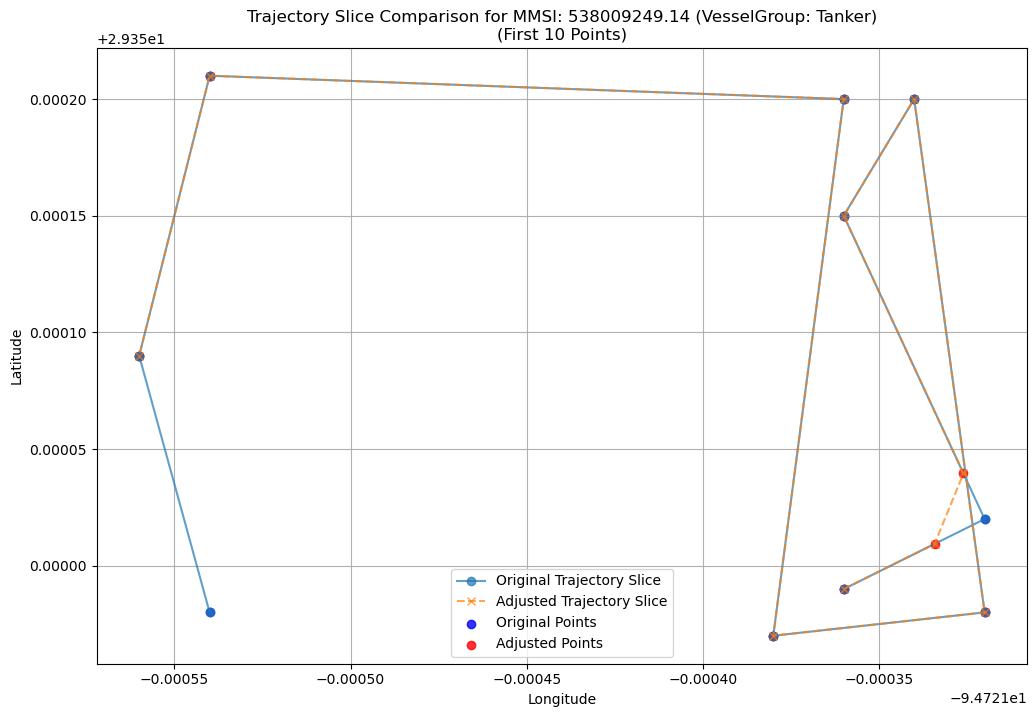

MMSI: 368217570.20, VesselGroup in Original: Passenger
MMSI: 368217570.20 (VesselGroup: Passenger)
Original and Adjusted Timestamps:
Point 1: Original Time = 2023-08-04 21:17:37, Adjusted Time = 2023-08-04 21:17:37
Point 2: Original Time = 2023-08-04 21:18:40, Adjusted Time = 2023-08-04 21:19:37
Point 3: Original Time = 2023-08-04 21:19:42, Adjusted Time = 2023-08-04 21:21:37
Point 4: Original Time = 2023-08-04 21:20:44, Adjusted Time = 2023-08-04 21:23:37
Point 5: Original Time = 2023-08-04 21:21:46, Adjusted Time = 2023-08-04 21:25:37
Point 6: Original Time = 2023-08-04 21:22:47, Adjusted Time = 2023-08-04 21:27:37
Point 7: Original Time = 2023-08-04 21:23:52, Adjusted Time = 2023-08-04 21:29:37
Point 8: Original Time = 2023-08-04 21:24:59, Adjusted Time = 2023-08-04 21:31:37
Point 9: Original Time = 2023-08-04 21:26:00, Adjusted Time = 2023-08-04 21:33:37
Point 10: Original Time = 2023-08-04 21:27:02, Adjusted Time = 2023-08-04 21:35:37


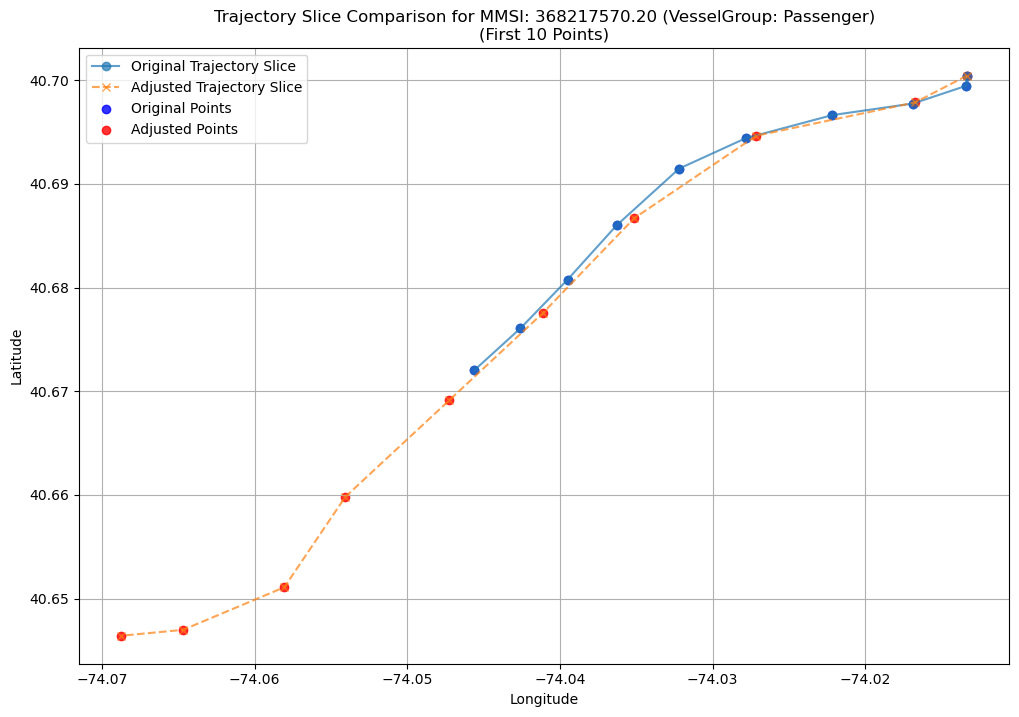

MMSI: 368067890.19, VesselGroup in Original: Tug
MMSI: 368067890.19 (VesselGroup: Tug)
Original and Adjusted Timestamps:
Point 1: Original Time = 2023-09-23 00:02:30, Adjusted Time = 2023-09-23 00:02:30
Point 2: Original Time = 2023-09-23 00:05:03, Adjusted Time = 2023-09-23 00:04:30
Point 3: Original Time = 2023-09-23 00:06:09, Adjusted Time = 2023-09-23 00:06:30
Point 4: Original Time = 2023-09-23 00:07:12, Adjusted Time = 2023-09-23 00:08:30
Point 5: Original Time = 2023-09-23 00:08:16, Adjusted Time = 2023-09-23 00:10:30
Point 6: Original Time = 2023-09-23 00:09:18, Adjusted Time = 2023-09-23 00:12:30
Point 7: Original Time = 2023-09-23 00:10:21, Adjusted Time = 2023-09-23 00:14:30
Point 8: Original Time = 2023-09-23 00:11:23, Adjusted Time = 2023-09-23 00:16:30
Point 9: Original Time = 2023-09-23 00:12:26, Adjusted Time = 2023-09-23 00:18:30
Point 10: Original Time = 2023-09-23 00:13:28, Adjusted Time = 2023-09-23 00:20:30


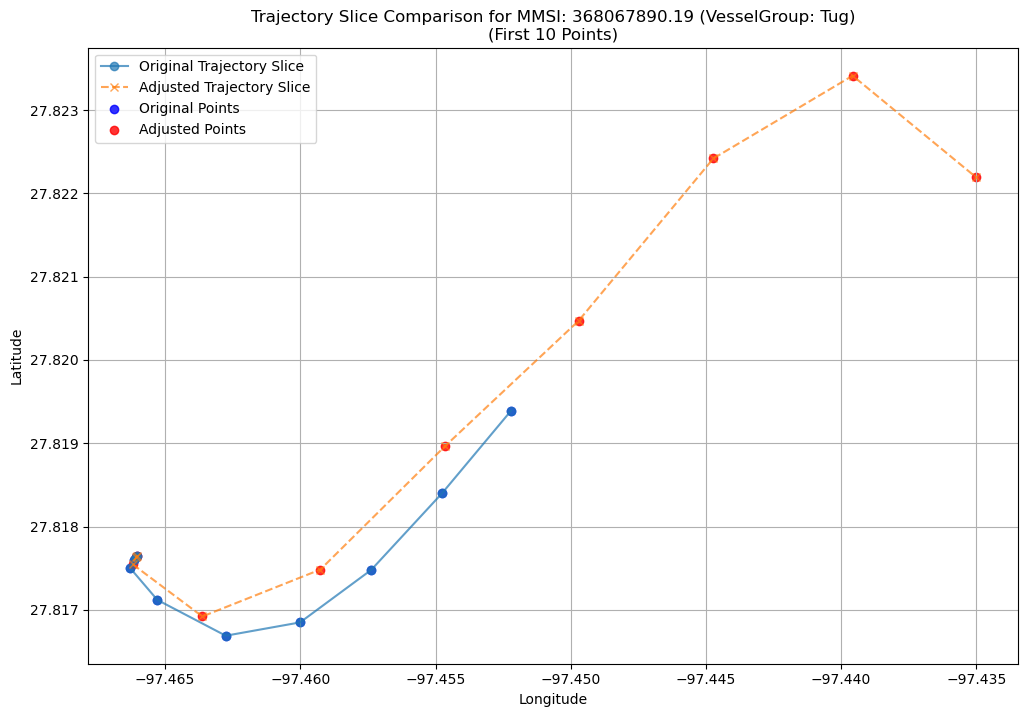

In [31]:
def compare_trajectory_slices_with_vesselgroup(
    original_df, adjusted_df, mmsi_list, timestamp_col='BaseDateTime', lat_col='LAT', lon_col='LON', vessel_group_col='VesselGroup', slice_size=10
):
    """
    Compare slices of original and adjusted trajectories by plotting a subset of points and including VesselGroup in the title.
    """
    original_df[timestamp_col] = pd.to_datetime(original_df[timestamp_col])
    adjusted_df[timestamp_col] = pd.to_datetime(adjusted_df[timestamp_col])

    for mmsi in mmsi_list:
        original_ship = original_df[original_df['MMSI'] == mmsi].reset_index(drop=True)
        adjusted_ship = adjusted_df[adjusted_df['MMSI'] == mmsi].reset_index(drop=True)

        if original_ship.empty or adjusted_ship.empty:
            print(f"Skipping MMSI {mmsi}: insufficient data for comparison.")
            continue

        vessel_group = original_ship[vessel_group_col].iloc[0] if not original_ship.empty else "Unknown"
        print(f"MMSI: {mmsi}, VesselGroup in Original: {vessel_group}")

        slice_size = min(slice_size, len(original_ship), len(adjusted_ship))
        original_slice = original_ship.iloc[:slice_size]
        adjusted_slice = adjusted_ship.iloc[:slice_size]

        print(f"MMSI: {mmsi} (VesselGroup: {vessel_group})")
        print("Original and Adjusted Timestamps:")
        for i in range(slice_size):
            original_time = original_slice[timestamp_col].iloc[i]
            adjusted_time = adjusted_slice[timestamp_col].iloc[i]
            print(f"Point {i + 1}: Original Time = {original_time}, Adjusted Time = {adjusted_time}")

        plt.figure(figsize=(12, 8))
        plt.plot(original_slice[lon_col], original_slice[lat_col], 'o-', label='Original Trajectory Slice', alpha=0.7)
        plt.plot(adjusted_slice[lon_col], adjusted_slice[lat_col], 'x--', label='Adjusted Trajectory Slice', alpha=0.7)

        plt.scatter(original_slice[lon_col], original_slice[lat_col], color='blue', label='Original Points', alpha=0.8)
        plt.scatter(adjusted_slice[lon_col], adjusted_slice[lat_col], color='red', label='Adjusted Points', alpha=0.8)

        plt.title(f'Trajectory Slice Comparison for MMSI: {mmsi} (VesselGroup: {vessel_group})\n'
                  f'(First {slice_size} Points)')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.legend()
        plt.grid(True)
        plt.show()

num_plots_per_class = 1

vessel_groups_of_interest = ["Tanker", "Passenger", "Tug"]
filtered_mmsi_list = []

for group in vessel_groups_of_interest:
    group_mmsis = df_cleaned_done[df_cleaned_done['VesselGroup'] == group]['MMSI'].drop_duplicates()
    sampled_mmsis = group_mmsis.sample(n=min(num_plots_per_class, len(group_mmsis)), random_state=42).tolist()
    filtered_mmsi_list.extend(sampled_mmsis)

compare_trajectory_slices_with_vesselgroup(
    original_df=df_cleaned_done,
    adjusted_df=df_advanced_adjusted,
    mmsi_list=filtered_mmsi_list,
    timestamp_col='BaseDateTime',
    lat_col='LAT',
    lon_col='LON',
    vessel_group_col='VesselGroup',
    slice_size=10  
)

/var/folders/tr/h8hn7kys66z1mmrpy46rxvwh0000gn/T/ipykernel_6982/1874311260.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_df[timestamp_col] = pd.to_datetime(original_df[timestamp_col])


MMSI: 538009249.14, VesselGroup in Original: Tanker
MMSI: 538009249.14 (VesselGroup: Tanker)
Original and Adjusted Timestamps:
Point 10: Original Time = 2023-12-14 23:26:00, Adjusted Time = 2023-12-14 22:09:02
Point 9: Original Time = 2023-12-14 23:29:05, Adjusted Time = 2023-12-14 22:11:02
Point 8: Original Time = 2023-12-14 23:35:06, Adjusted Time = 2023-12-14 22:13:02
Point 7: Original Time = 2023-12-14 23:38:03, Adjusted Time = 2023-12-14 22:15:02
Point 6: Original Time = 2023-12-14 23:41:05, Adjusted Time = 2023-12-14 22:17:02
Point 5: Original Time = 2023-12-14 23:44:05, Adjusted Time = 2023-12-14 22:19:02
Point 4: Original Time = 2023-12-14 23:47:00, Adjusted Time = 2023-12-14 22:21:02
Point 3: Original Time = 2023-12-14 23:50:05, Adjusted Time = 2023-12-14 22:23:02
Point 2: Original Time = 2023-12-14 23:53:01, Adjusted Time = 2023-12-14 22:25:02
Point 1: Original Time = 2023-12-14 23:59:04, Adjusted Time = 2023-12-14 22:27:02


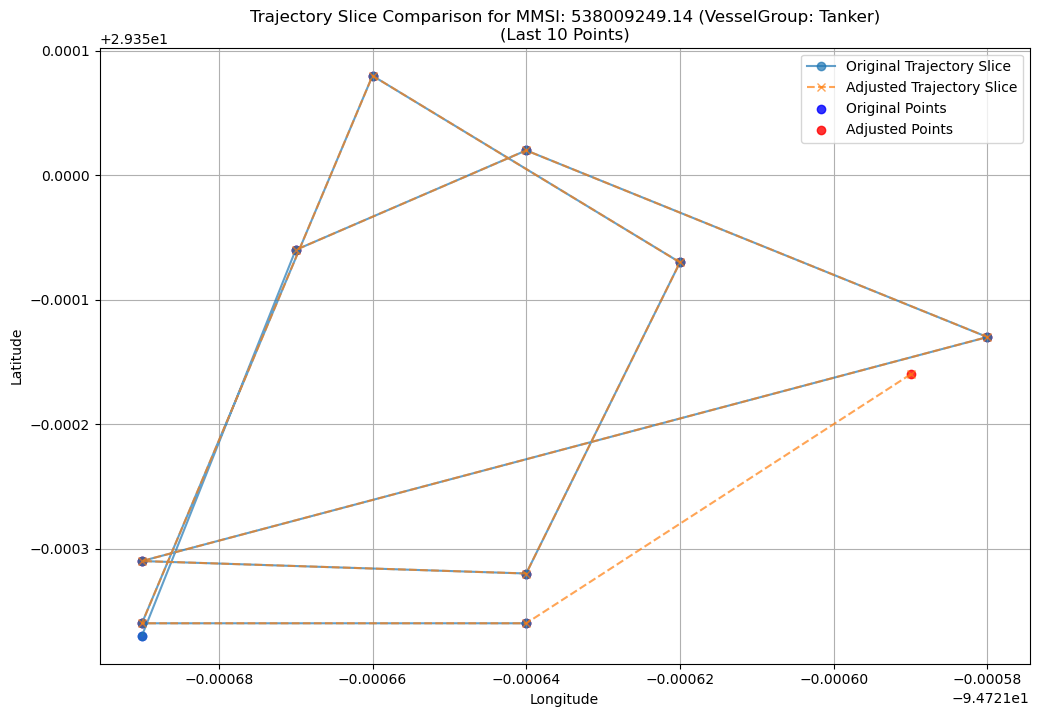

MMSI: 368217570.20, VesselGroup in Original: Passenger
MMSI: 368217570.20 (VesselGroup: Passenger)
Original and Adjusted Timestamps:
Point 10: Original Time = 2023-08-04 23:23:21, Adjusted Time = 2023-08-04 23:23:37
Point 9: Original Time = 2023-08-04 23:25:11, Adjusted Time = 2023-08-04 23:25:37
Point 8: Original Time = 2023-08-04 23:27:32, Adjusted Time = 2023-08-04 23:27:37
Point 7: Original Time = 2023-08-04 23:30:10, Adjusted Time = 2023-08-04 23:29:37
Point 6: Original Time = 2023-08-04 23:33:05, Adjusted Time = 2023-08-04 23:31:37
Point 5: Original Time = 2023-08-04 23:35:29, Adjusted Time = 2023-08-04 23:33:37
Point 4: Original Time = 2023-08-04 23:37:22, Adjusted Time = 2023-08-04 23:35:37
Point 3: Original Time = 2023-08-04 23:39:04, Adjusted Time = 2023-08-04 23:37:37
Point 2: Original Time = 2023-08-04 23:40:11, Adjusted Time = 2023-08-04 23:39:37
Point 1: Original Time = 2023-08-04 23:42:27, Adjusted Time = 2023-08-04 23:41:37


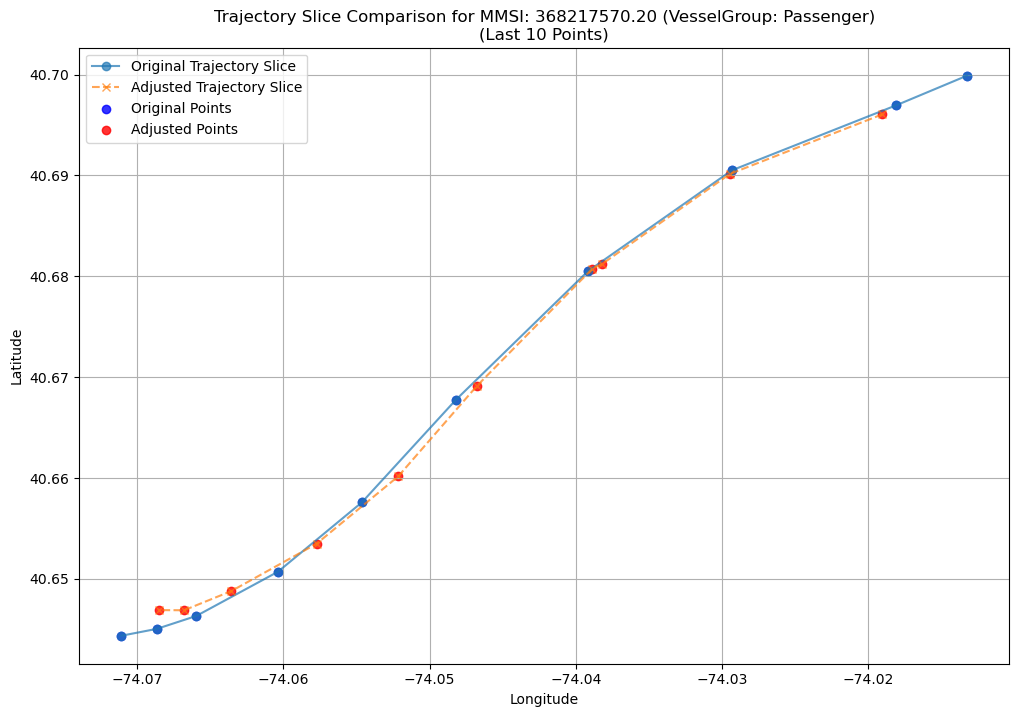

MMSI: 368067890.19, VesselGroup in Original: Tug
MMSI: 368067890.19 (VesselGroup: Tug)
Original and Adjusted Timestamps:
Point 10: Original Time = 2023-09-23 00:29:56, Adjusted Time = 2023-09-23 00:20:30
Point 9: Original Time = 2023-09-23 00:30:59, Adjusted Time = 2023-09-23 00:22:30
Point 8: Original Time = 2023-09-23 00:32:01, Adjusted Time = 2023-09-23 00:24:30
Point 7: Original Time = 2023-09-23 00:33:02, Adjusted Time = 2023-09-23 00:26:30
Point 6: Original Time = 2023-09-23 00:34:03, Adjusted Time = 2023-09-23 00:28:30
Point 5: Original Time = 2023-09-23 00:35:08, Adjusted Time = 2023-09-23 00:30:30
Point 4: Original Time = 2023-09-23 00:36:10, Adjusted Time = 2023-09-23 00:32:30
Point 3: Original Time = 2023-09-23 00:37:12, Adjusted Time = 2023-09-23 00:34:30
Point 2: Original Time = 2023-09-23 00:39:22, Adjusted Time = 2023-09-23 00:36:30
Point 1: Original Time = 2023-09-23 00:40:24, Adjusted Time = 2023-09-23 00:38:30


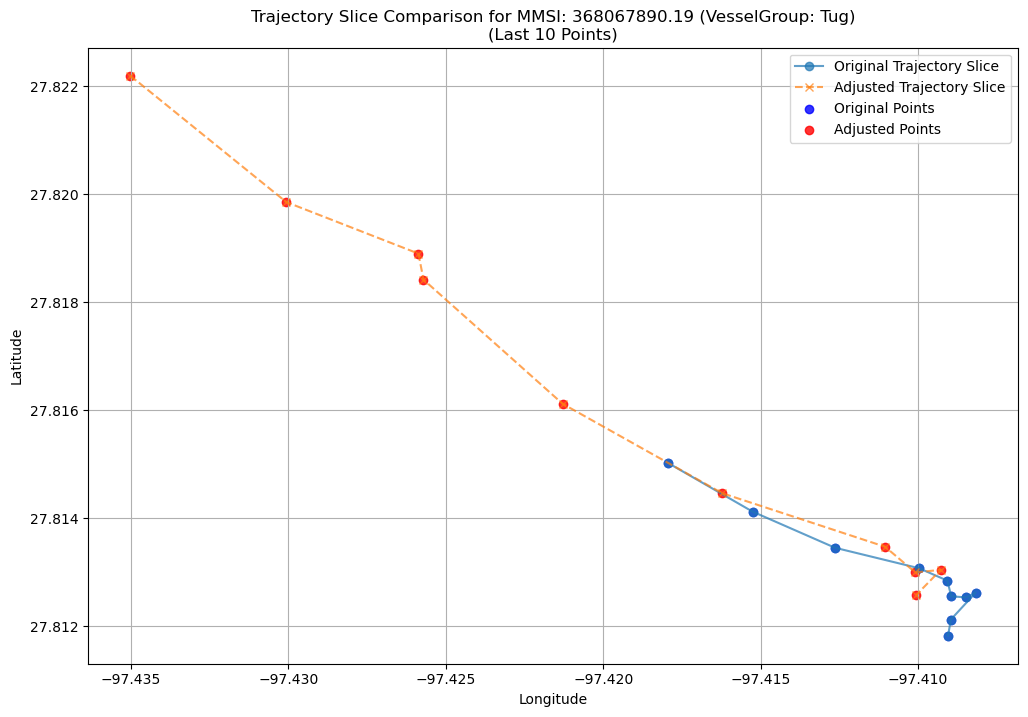

In [32]:
def compare_trajectory_slices_with_vesselgroup(
    original_df, adjusted_df, mmsi_list, timestamp_col='BaseDateTime', lat_col='LAT', lon_col='LON', vessel_group_col='VesselGroup', slice_size=10
):
    """
    Compare slices of original and adjusted trajectories by plotting the last subset of points and including VesselGroup in the title.
    """
    original_df[timestamp_col] = pd.to_datetime(original_df[timestamp_col])
    adjusted_df[timestamp_col] = pd.to_datetime(adjusted_df[timestamp_col])

    for mmsi in mmsi_list:
        original_ship = original_df[original_df['MMSI'] == mmsi].reset_index(drop=True)
        adjusted_ship = adjusted_df[adjusted_df['MMSI'] == mmsi].reset_index(drop=True)

        if original_ship.empty or adjusted_ship.empty:
            print(f"Skipping MMSI {mmsi}: insufficient data for comparison.")
            continue

        vessel_group = original_ship[vessel_group_col].iloc[0] if not original_ship.empty else "Unknown"
        print(f"MMSI: {mmsi}, VesselGroup in Original: {vessel_group}")

        slice_size = min(slice_size, len(original_ship), len(adjusted_ship))
        original_slice = original_ship.iloc[-slice_size:] 
        adjusted_slice = adjusted_ship.iloc[-slice_size:] 

        print(f"MMSI: {mmsi} (VesselGroup: {vessel_group})")
        print("Original and Adjusted Timestamps:")
        for i in range(slice_size):
            original_time = original_slice[timestamp_col].iloc[i]
            adjusted_time = adjusted_slice[timestamp_col].iloc[i]
            print(f"Point {slice_size - i}: Original Time = {original_time}, Adjusted Time = {adjusted_time}")

        plt.figure(figsize=(12, 8))
        plt.plot(original_slice[lon_col], original_slice[lat_col], 'o-', label='Original Trajectory Slice', alpha=0.7)
        plt.plot(adjusted_slice[lon_col], adjusted_slice[lat_col], 'x--', label='Adjusted Trajectory Slice', alpha=0.7)

        plt.scatter(original_slice[lon_col], original_slice[lat_col], color='blue', label='Original Points', alpha=0.8)
        plt.scatter(adjusted_slice[lon_col], adjusted_slice[lat_col], color='red', label='Adjusted Points', alpha=0.8)

        plt.title(f'Trajectory Slice Comparison for MMSI: {mmsi} (VesselGroup: {vessel_group})\n'
                  f'(Last {slice_size} Points)')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.legend()
        plt.grid(True)
        plt.show()

num_plots_per_class = 1

vessel_groups_of_interest = ["Tanker", "Passenger", "Tug"]
filtered_mmsi_list = []

for group in vessel_groups_of_interest:
    group_mmsis = df_cleaned_done[df_cleaned_done['VesselGroup'] == group]['MMSI'].drop_duplicates()
    sampled_mmsis = group_mmsis.sample(n=min(num_plots_per_class, len(group_mmsis)), random_state=42).tolist()
    filtered_mmsi_list.extend(sampled_mmsis)

# Call the function to compare trajectory slices with VesselGroup in title
compare_trajectory_slices_with_vesselgroup(
    original_df=df_cleaned_done,
    adjusted_df=df_advanced_adjusted,
    mmsi_list=filtered_mmsi_list,
    timestamp_col='BaseDateTime',
    lat_col='LAT',
    lon_col='LON',
    vessel_group_col='VesselGroup',
    slice_size=10
)

# 5. Preparing Final Dataframes

In [33]:
df_advanced_adjusted['MMSI'] = df_advanced_adjusted['MMSI'].astype('float64')
print(df_advanced_adjusted['MMSI'].dtype) 
summarize_dataframe(df_advanced_adjusted)

float64


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,205042000.1,2023-01-01 00:00:25,32.332470,-119.905500,2.100000,119.200000,DELOS,Tanker
1,205042000.1,2023-01-01 00:02:25,32.331883,-119.904351,1.929787,123.285106,DELOS,Tanker
2,205042000.1,2023-01-01 00:04:25,32.331276,-119.903186,1.980383,122.656938,DELOS,Tanker
3,205042000.1,2023-01-01 00:06:25,32.330658,-119.902030,2.055872,121.661922,DELOS,Tanker
4,205042000.1,2023-01-01 00:08:25,32.330037,-119.900876,1.803943,126.548746,DELOS,Tanker
...,...,...,...,...,...,...,...,...
1992215,987654321.8,2023-08-04 20:06:26,40.711694,-74.041820,0.617005,133.594292,ME AND THE BOYS,Passenger
1992216,987654321.8,2023-08-04 20:08:26,40.711943,-74.040992,0.593020,104.976783,ME AND THE BOYS,Passenger
1992217,987654321.8,2023-08-04 20:10:26,40.713753,-74.037351,1.094511,112.179497,ME AND THE BOYS,Passenger
1992218,987654321.8,2023-08-04 20:12:26,40.711824,-74.040901,0.520058,107.460465,ME AND THE BOYS,Passenger


The dataframe contains 1,992,220 rows.

There are 3 unique vessel groups.
The unique vessel groups are: ['Tanker' 'Tug' 'Passenger']

Row counts for each vessel group:
Group Tanker: 629,466 rows
Group Tug: 353,830 rows
Group Passenger: 1,008,924 rows


In [34]:
groups = df_advanced_adjusted['VesselGroup'].unique()
print(groups)
print(groups[0])
print(groups[1])
print(groups[2])

['Tanker' 'Tug' 'Passenger']
Tanker
Tug
Passenger


In [35]:
df_group_1 = df_advanced_adjusted[df_advanced_adjusted['VesselGroup'] == groups[0]]
display(df_group_1)
print(df_group_1['VesselGroup'].unique())
print(df_group_1['VesselGroup'].nunique())

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,205042000.1,2023-01-01 00:00:25,32.332470,-119.905500,2.100000,119.200000,DELOS,Tanker
1,205042000.1,2023-01-01 00:02:25,32.331883,-119.904351,1.929787,123.285106,DELOS,Tanker
2,205042000.1,2023-01-01 00:04:25,32.331276,-119.903186,1.980383,122.656938,DELOS,Tanker
3,205042000.1,2023-01-01 00:06:25,32.330658,-119.902030,2.055872,121.661922,DELOS,Tanker
4,205042000.1,2023-01-01 00:08:25,32.330037,-119.900876,1.803943,126.548746,DELOS,Tanker
...,...,...,...,...,...,...,...,...
1991505,710025780.8,2023-09-23 07:58:28,48.861130,-122.759340,0.100000,194.100000,JOSE DO PATROCINIO,Tanker
1991506,710025780.8,2023-09-23 08:00:28,48.861140,-122.759340,0.100000,189.600000,JOSE DO PATROCINIO,Tanker
1991507,710025780.8,2023-09-23 08:02:28,48.861130,-122.759370,0.100000,186.600000,JOSE DO PATROCINIO,Tanker
1991508,710025780.8,2023-09-23 08:04:28,48.861110,-122.759380,0.100000,187.900000,JOSE DO PATROCINIO,Tanker


['Tanker']
1


In [36]:
df_group_2 = df_advanced_adjusted[df_advanced_adjusted['VesselGroup'] == groups[1]]
display(df_group_2)
print(df_group_2['VesselGroup'].unique())
print(df_group_2['VesselGroup'].nunique())

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
1778,205644000.1,2023-08-04 00:00:03,41.099030,-71.183180,0.200000,324.500000,SOVEREIGN,Tug
1779,205644000.1,2023-08-04 00:02:03,41.099030,-71.183198,0.140299,228.320896,SOVEREIGN,Tug
1780,205644000.1,2023-08-04 00:04:03,41.099036,-71.183210,0.211429,164.792857,SOVEREIGN,Tug
1781,205644000.1,2023-08-04 00:06:03,41.099015,-71.183197,0.300000,169.968571,SOVEREIGN,Tug
1782,205644000.1,2023-08-04 00:08:03,41.098990,-71.183190,0.300000,323.500000,SOVEREIGN,Tug
...,...,...,...,...,...,...,...,...
1991833,730152579.3,2023-05-05 23:06:58,12.251880,-71.959460,0.100000,246.900000,CIUDAD DE URIBIA,Tug
1991834,730152579.3,2023-05-05 23:08:58,12.251880,-71.959450,0.100000,245.200000,CIUDAD DE URIBIA,Tug
1991835,730152579.3,2023-05-05 23:10:58,12.251890,-71.959460,0.100000,252.400000,CIUDAD DE URIBIA,Tug
1991836,730152579.3,2023-05-05 23:12:58,12.251880,-71.959430,0.100000,254.500000,CIUDAD DE URIBIA,Tug


['Tug']
1


In [37]:
df_group_3 = df_advanced_adjusted[df_advanced_adjusted['VesselGroup'] == groups[2]]
display(df_group_3)
print(df_group_3['VesselGroup'].unique())
print(df_group_3['VesselGroup'].nunique())

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
7656,212259000.1,2023-01-01 01:02:29,48.422700,-123.373740,0.300000,107.800000,HALUNDER JET,Passenger
7657,212259000.1,2023-01-01 01:04:29,48.424785,-123.375933,5.218033,300.980328,HALUNDER JET,Passenger
7658,212259000.1,2023-01-01 01:06:29,48.424992,-123.380753,5.894709,274.131217,HALUNDER JET,Passenger
7659,212259000.1,2023-01-01 01:08:29,48.424914,-123.385362,5.555914,270.675269,HALUNDER JET,Passenger
7660,212259000.1,2023-01-01 01:10:29,48.423414,-123.388559,5.600865,214.945533,HALUNDER JET,Passenger
...,...,...,...,...,...,...,...,...
1992215,987654321.8,2023-08-04 20:06:26,40.711694,-74.041820,0.617005,133.594292,ME AND THE BOYS,Passenger
1992216,987654321.8,2023-08-04 20:08:26,40.711943,-74.040992,0.593020,104.976783,ME AND THE BOYS,Passenger
1992217,987654321.8,2023-08-04 20:10:26,40.713753,-74.037351,1.094511,112.179497,ME AND THE BOYS,Passenger
1992218,987654321.8,2023-08-04 20:12:26,40.711824,-74.040901,0.520058,107.460465,ME AND THE BOYS,Passenger


['Passenger']
1


In [38]:
rows_group_1 = len(df_group_1)
rows_group_2 = len(df_group_2)
rows_group_3 = len(df_group_3)

total_rows_groups = rows_group_1 + rows_group_2 + rows_group_3

rows_original = len(df_advanced_adjusted)

print(f"Rows in Group 0 (df_group_0): {rows_group_1}")
print(f"Rows in Group 1 (df_group_1): {rows_group_2}")
print(f"Rows in Group 2 (df_group_2): {rows_group_3}")
print(f"Total rows in groups (Group 0 + Group 1 + Group 2): {total_rows_groups}")
print(f"Rows in Original DataFrame (df_original): {rows_original}")

if total_rows_groups == rows_original:
    print("The total rows from all group DataFrames match the rows in the original DataFrame.")
else:
    print("There is a mismatch between the total rows from all group DataFrames and the original DataFrame.")

Rows in Group 0 (df_group_0): 629466
Rows in Group 1 (df_group_1): 353830
Rows in Group 2 (df_group_2): 1008924
Total rows in groups (Group 0 + Group 1 + Group 2): 1992220
Rows in Original DataFrame (df_original): 1992220
The total rows from all group DataFrames match the rows in the original DataFrame.


In [39]:
from sklearn.model_selection import train_test_split

def split_group_by_mmsi(df, train_ratio=0.75, val_ratio=0.1, test_ratio=0.15, random_seed=42):
    """
    Splits a DataFrame into training, validation, and test sets based on MMSI.

    Parameters:
        df (DataFrame): Input DataFrame for a single vessel group.
        train_ratio (float): Proportion of the data for training.
        val_ratio (float): Proportion of the data for validation.
        test_ratio (float): Proportion of the data for testing.
        random_seed (int): Random seed for reproducibility.

    Returns:
        tuple: Three DataFrames for training, validation, and testing.
    """
    assert train_ratio + val_ratio + test_ratio == 1, "Ratios must sum to 1."

    mmsi_list = df['MMSI'].unique()

    train_mmsi, temp_mmsi = train_test_split(mmsi_list, test_size=(val_ratio + test_ratio), random_state=random_seed)
    val_mmsi, test_mmsi = train_test_split(temp_mmsi, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=random_seed)

    train_df = df[df['MMSI'].isin(train_mmsi)]
    val_df = df[df['MMSI'].isin(val_mmsi)]
    test_df = df[df['MMSI'].isin(test_mmsi)]

    return train_df, val_df, test_df

train_group_0, val_group_0, test_group_0 = split_group_by_mmsi(df_group_1)
train_group_1, val_group_1, test_group_1 = split_group_by_mmsi(df_group_2)
train_group_2, val_group_2, test_group_2 = split_group_by_mmsi(df_group_3)

train_df = pd.concat([train_group_0, train_group_1, train_group_2]).reset_index(drop=True)
val_df = pd.concat([val_group_0, val_group_1, val_group_2]).reset_index(drop=True)
test_df = pd.concat([test_group_0, test_group_1, test_group_2]).reset_index(drop=True)

print(f"Training DataFrame: {len(train_df)} rows")
print(f"Validation DataFrame: {len(val_df)} rows")
print(f"Testing DataFrame: {len(test_df)} rows")

Training DataFrame: 1495823 rows
Validation DataFrame: 201938 rows
Testing DataFrame: 294459 rows


In [40]:
print(f"\n===== Train Data =====")

display(train_df)
unique_vessel_groups_train = train_df['VesselGroup'].unique()
num_vessel_groups_train = train_df['VesselGroup'].nunique()
print(f"There are {num_vessel_groups_train} unique vessel groups.")
print(f"The unique vessel types groups: {unique_vessel_groups_train}")

print(f"\n===== Test Data =====")

display(test_df)
unique_vessel_groups_train = test_df['VesselGroup'].unique()
num_vessel_groups_train = test_df['VesselGroup'].nunique()
print(f"There are {num_vessel_groups_train} unique vessel groups.")
print(f"The unique vessel types groups: {unique_vessel_groups_train}")

print(f"\n===== Validation Data =====")

display(val_df)
unique_vessel_groups_train = val_df['VesselGroup'].unique()
num_vessel_groups_train = val_df['VesselGroup'].nunique()
print(f"There are {num_vessel_groups_train} unique vessel groups.")
print(f"The unique vessel types groups: {unique_vessel_groups_train}")


===== Train Data =====


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,205042000.1,2023-01-01 00:00:25,32.332470,-119.905500,2.100000,119.200000,DELOS,Tanker
1,205042000.1,2023-01-01 00:02:25,32.331883,-119.904351,1.929787,123.285106,DELOS,Tanker
2,205042000.1,2023-01-01 00:04:25,32.331276,-119.903186,1.980383,122.656938,DELOS,Tanker
3,205042000.1,2023-01-01 00:06:25,32.330658,-119.902030,2.055872,121.661922,DELOS,Tanker
4,205042000.1,2023-01-01 00:08:25,32.330037,-119.900876,1.803943,126.548746,DELOS,Tanker
...,...,...,...,...,...,...,...,...
1495818,982464421.9,2023-05-05 19:08:52,44.405340,-68.204600,0.600000,15.800000,T/T ZAANDAM 9,Passenger
1495819,982464421.9,2023-05-05 19:10:52,44.405880,-68.204530,0.300000,360.000000,T/T ZAANDAM 9,Passenger
1495820,982464421.9,2023-05-05 19:12:52,44.406060,-68.204600,2.100000,273.600000,T/T ZAANDAM 9,Passenger
1495821,982464421.9,2023-05-05 19:14:52,44.406220,-68.204850,0.800000,69.400000,T/T ZAANDAM 9,Passenger


There are 3 unique vessel groups.
The unique vessel types groups: ['Tanker' 'Tug' 'Passenger']

===== Test Data =====


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,2.050890e+08,2023-09-23 23:02:27,28.244850,-94.752440,0.700000,202.200000,DICKENS,Tanker
1,2.050890e+08,2023-09-23 23:04:27,28.244452,-94.752642,0.700000,204.600000,DICKENS,Tanker
2,2.050890e+08,2023-09-23 23:06:27,28.244092,-94.752848,0.700000,207.468807,DICKENS,Tanker
3,2.050890e+08,2023-09-23 23:08:27,28.243735,-94.753050,0.700000,207.947170,DICKENS,Tanker
4,2.050890e+08,2023-09-23 23:10:27,28.243326,-94.753302,0.789247,205.525806,DICKENS,Tanker
...,...,...,...,...,...,...,...,...
294454,9.824644e+08,2023-05-05 19:39:25,44.405780,-68.207220,3.900000,167.400000,T/T ZAANDAM 12,Passenger
294455,9.824644e+08,2023-05-05 19:41:25,44.405660,-68.204550,2.700000,62.800000,T/T ZAANDAM 12,Passenger
294456,9.824644e+08,2023-05-05 19:43:25,44.406060,-68.204390,0.200000,360.000000,T/T ZAANDAM 12,Passenger
294457,9.824644e+08,2023-05-05 19:45:25,44.406230,-68.204290,0.400000,18.300000,T/T ZAANDAM 12,Passenger


There are 3 unique vessel groups.
The unique vessel types groups: ['Tanker' 'Tug' 'Passenger']

===== Validation Data =====


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,210106000.7,2023-05-05 12:47:44,27.626050,-92.320760,11.400000,312.100000,VIRGEN DE LA AURORA,Tanker
1,210106000.7,2023-05-05 12:49:44,27.630315,-92.326012,11.492308,312.284615,VIRGEN DE LA AURORA,Tanker
2,210106000.7,2023-05-05 12:51:44,27.634665,-92.331430,11.645205,312.118265,VIRGEN DE LA AURORA,Tanker
3,210106000.7,2023-05-05 12:53:44,27.639143,-92.336931,11.656818,312.090909,VIRGEN DE LA AURORA,Tanker
4,210106000.7,2023-05-05 12:55:44,27.643562,-92.342396,11.727027,311.948649,VIRGEN DE LA AURORA,Tanker
...,...,...,...,...,...,...,...,...
201933,987654321.8,2023-08-04 20:06:26,40.711694,-74.041820,0.617005,133.594292,ME AND THE BOYS,Passenger
201934,987654321.8,2023-08-04 20:08:26,40.711943,-74.040992,0.593020,104.976783,ME AND THE BOYS,Passenger
201935,987654321.8,2023-08-04 20:10:26,40.713753,-74.037351,1.094511,112.179497,ME AND THE BOYS,Passenger
201936,987654321.8,2023-08-04 20:12:26,40.711824,-74.040901,0.520058,107.460465,ME AND THE BOYS,Passenger


There are 3 unique vessel groups.
The unique vessel types groups: ['Tanker' 'Tug' 'Passenger']


In [41]:
def random_subsample_by_mmsi_balanced(df, sample_size, random_seed):
    """
    Randomly subsamples a DataFrame without splitting sequences across MMSI values,
    ensuring balanced row counts for each VesselGroup.

    Parameters:
        df (DataFrame): The input DataFrame to subsample.
        sample_size (int): The desired number of rows in the subsample.
        random_seed (int): Random seed for reproducibility.

    Returns:
        DataFrame: A randomly subsampled DataFrame with the specified number of rows,
                   balanced across VesselGroups.
    """
    if sample_size >= len(df):
        return df

 
    np.random.seed(random_seed)

    vessel_groups = df['VesselGroup'].unique()

    rows_per_group = sample_size // len(vessel_groups)

    subsampled_df = pd.DataFrame()

    for group in vessel_groups:
        group_df = df[df['VesselGroup'] == group]

        unique_mmsis = group_df['MMSI'].unique()
        np.random.shuffle(unique_mmsis)

        group_subsampled_df = pd.DataFrame()
        total_rows = 0

        for mmsi in unique_mmsis:
            mmsi_rows = group_df[group_df['MMSI'] == mmsi]
            group_subsampled_df = pd.concat([group_subsampled_df, mmsi_rows], axis=0)
            total_rows += len(mmsi_rows)

            if total_rows >= rows_per_group:
                break

        subsampled_df = pd.concat([subsampled_df, group_subsampled_df])

    return subsampled_df.reset_index(drop=True)

In [42]:
subsample_size_train = 200000
subsample_size_test = 40000
subsample_size_val = 27000

seed_train = current_seed
seed_test = current_seed * 2
seed_val = current_seed * 3

train_subsample = random_subsample_by_mmsi_balanced(train_df, subsample_size_train, random_seed=seed_train)
test_subsample = random_subsample_by_mmsi_balanced(test_df, subsample_size_test, random_seed=seed_test)
val_subsample = random_subsample_by_mmsi_balanced(val_df, subsample_size_val, random_seed=seed_val)

print(f"Train subsample size: {len(train_subsample)} rows")
print(train_subsample['VesselGroup'].value_counts())
print(f"Test subsample size: {len(test_subsample)} rows")
print(test_subsample['VesselGroup'].value_counts())
print(f"Validation subsample size: {len(val_subsample)} rows")
print(val_subsample['VesselGroup'].value_counts())

Train subsample size: 200258 rows
VesselGroup
Passenger    66809
Tug          66728
Tanker       66721
Name: count, dtype: int64
Test subsample size: 40745 rows
VesselGroup
Tanker       13958
Passenger    13433
Tug          13354
Name: count, dtype: int64
Validation subsample size: 27152 rows
VesselGroup
Tug          9072
Passenger    9057
Tanker       9023
Name: count, dtype: int64


In [43]:
print(f"\n===== Train Data Subsammple =====")

display(train_subsample)
unique_vessel_groups_train = train_subsample['VesselGroup'].unique()
num_vessel_groups_train = train_subsample['VesselGroup'].nunique()
print(f"There are {num_vessel_groups_train} unique vessel groups.")
print(f"The unique vessel types groups: {unique_vessel_groups_train}")

print(f"\n===== Train Data Subsammple =====")

display(test_subsample)
unique_vessel_groups_train = test_subsample['VesselGroup'].unique()
num_vessel_groups_train = test_subsample['VesselGroup'].nunique()
print(f"There are {num_vessel_groups_train} unique vessel groups.")
print(f"The unique vessel types groups: {unique_vessel_groups_train}")

print(f"\n===== Train Data Subsammple =====")

display(val_subsample)
unique_vessel_groups_train = val_subsample['VesselGroup'].unique()
num_vessel_groups_train = val_subsample['VesselGroup'].nunique()
print(f"There are {num_vessel_groups_train} unique vessel groups.")
print(f"The unique vessel types groups: {unique_vessel_groups_train}")


===== Train Data Subsammple =====


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,538005775.1,2023-05-05 21:39:27,29.747110,-95.098320,0.600000,270.200000,NAVIG8 ANDESINE,Tanker
1,538005775.1,2023-05-05 21:41:27,29.747296,-95.098903,0.938028,286.171831,NAVIG8 ANDESINE,Tanker
2,538005775.1,2023-05-05 21:43:27,29.747502,-95.099658,1.302381,283.942381,NAVIG8 ANDESINE,Tanker
3,538005775.1,2023-05-05 21:45:27,29.747463,-95.100071,0.419772,190.295437,NAVIG8 ANDESINE,Tanker
4,538005775.1,2023-05-05 21:47:27,29.748040,-95.099394,2.319033,88.353172,NAVIG8 ANDESINE,Tanker
...,...,...,...,...,...,...,...,...
200253,311263000.4,2023-09-23 10:07:50,26.087573,-80.118574,0.734690,183.877168,ADVENTURE OFTHE SEAS,Passenger
200254,311263000.4,2023-09-23 10:09:50,26.087352,-80.117670,0.471329,200.623077,ADVENTURE OFTHE SEAS,Passenger
200255,311263000.4,2023-09-23 10:11:50,26.087212,-80.117176,0.295261,159.605863,ADVENTURE OFTHE SEAS,Passenger
200256,311263000.4,2023-09-23 10:13:50,26.087236,-80.115827,0.252927,132.876412,ADVENTURE OFTHE SEAS,Passenger


There are 3 unique vessel groups.
The unique vessel types groups: ['Tanker' 'Tug' 'Passenger']

===== Train Data Subsammple =====


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,5.380036e+08,2023-09-23 13:37:00,38.952600,-75.193630,0.100000,124.000000,DUBAI CHARM,Tanker
1,5.380036e+08,2023-09-23 13:39:00,38.952520,-75.193489,0.234078,117.966480,DUBAI CHARM,Tanker
2,5.380036e+08,2023-09-23 13:41:00,38.952436,-75.193319,0.266484,118.351648,DUBAI CHARM,Tanker
3,5.380036e+08,2023-09-23 13:43:00,38.952350,-75.193120,0.200000,125.000000,DUBAI CHARM,Tanker
4,5.380036e+08,2023-09-23 13:45:00,38.952470,-75.193220,0.100000,330.000000,DUBAI CHARM,Tanker
...,...,...,...,...,...,...,...,...
40740,3.671009e+08,2023-01-01 23:49:49,33.898416,-78.014549,14.074643,141.324849,RANGER,Passenger
40741,3.671009e+08,2023-01-01 23:51:49,33.895126,-78.011521,13.892473,146.386689,RANGER,Passenger
40742,3.671009e+08,2023-01-01 23:53:49,33.887660,-78.006400,13.878501,153.209749,RANGER,Passenger
40743,3.671009e+08,2023-01-01 23:55:49,33.880261,-78.004273,13.770796,184.075461,RANGER,Passenger


There are 3 unique vessel groups.
The unique vessel types groups: ['Tanker' 'Tug' 'Passenger']

===== Train Data Subsammple =====


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,6.360152e+08,2023-08-04 20:25:27,49.290930,-122.954360,0.200000,224.900000,AQUALEADER,Tanker
1,6.360152e+08,2023-08-04 20:27:27,49.290914,-122.955179,0.878261,259.960870,AQUALEADER,Tanker
2,6.360152e+08,2023-08-04 20:29:27,49.290930,-122.956036,1.514286,292.400000,AQUALEADER,Tanker
3,6.360152e+08,2023-08-04 20:31:27,49.291327,-122.957435,1.860870,291.504348,AQUALEADER,Tanker
4,6.360152e+08,2023-08-04 20:33:27,49.291773,-122.959715,2.640000,287.461667,AQUALEADER,Tanker
...,...,...,...,...,...,...,...,...
27147,3.160266e+08,2023-05-05 20:40:42,43.087990,-79.071110,6.800000,225.500000,NIAGARA THUNDER,Passenger
27148,3.160266e+08,2023-05-05 20:42:42,43.087370,-79.072200,0.100000,351.700000,NIAGARA THUNDER,Passenger
27149,3.160266e+08,2023-05-05 20:44:42,43.087510,-79.071400,3.100000,102.800000,NIAGARA THUNDER,Passenger
27150,3.160266e+08,2023-05-05 20:46:42,43.085860,-79.071580,4.000000,208.700000,NIAGARA THUNDER,Passenger


There are 3 unique vessel groups.
The unique vessel types groups: ['Tanker' 'Tug' 'Passenger']


In [44]:
print(train_subsample['MMSI'].dtype)
print(test_subsample['MMSI'].dtype)
print(val_subsample['MMSI'].dtype)

float64
float64
float64


In [45]:
# Check if MMSIs are unique across the subsamples
print("Overlap between train and test:", set(train_subsample['MMSI']).intersection(test_subsample['MMSI']))
print("Overlap between train and validation:", set(train_subsample['MMSI']).intersection(val_subsample['MMSI']))
print("Overlap between validation and test:", set(val_subsample['MMSI']).intersection(test_subsample['MMSI']))

Overlap between train and test: set()
Overlap between train and validation: set()
Overlap between validation and test: set()


In [46]:
assert not set(train_subsample['MMSI']).intersection(test_subsample['MMSI']), "Overlap found between train and test"
assert not set(train_subsample['MMSI']).intersection(val_subsample['MMSI']), "Overlap found between train and validation"
assert not set(val_subsample['MMSI']).intersection(test_subsample['MMSI']), "Overlap found between validation and test"

print("MMSIs are unique across all subsamples.")

MMSIs are unique across all subsamples.


In [47]:
summarize_dataframe(train_subsample)
summarize_dataframe(test_subsample)
summarize_dataframe(val_subsample)

,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,538005775.1,2023-05-05 21:39:27,29.747110,-95.098320,0.600000,270.200000,NAVIG8 ANDESINE,Tanker
1,538005775.1,2023-05-05 21:41:27,29.747296,-95.098903,0.938028,286.171831,NAVIG8 ANDESINE,Tanker
2,538005775.1,2023-05-05 21:43:27,29.747502,-95.099658,1.302381,283.942381,NAVIG8 ANDESINE,Tanker
3,538005775.1,2023-05-05 21:45:27,29.747463,-95.100071,0.419772,190.295437,NAVIG8 ANDESINE,Tanker
4,538005775.1,2023-05-05 21:47:27,29.748040,-95.099394,2.319033,88.353172,NAVIG8 ANDESINE,Tanker
...,...,...,...,...,...,...,...,...
200253,311263000.4,2023-09-23 10:07:50,26.087573,-80.118574,0.734690,183.877168,ADVENTURE OFTHE SEAS,Passenger
200254,311263000.4,2023-09-23 10:09:50,26.087352,-80.117670,0.471329,200.623077,ADVENTURE OFTHE SEAS,Passenger
200255,311263000.4,2023-09-23 10:11:50,26.087212,-80.117176,0.295261,159.605863,ADVENTURE OFTHE SEAS,Passenger
200256,311263000.4,2023-09-23 10:13:50,26.087236,-80.115827,0.252927,132.876412,ADVENTURE OFTHE SEAS,Passenger


The dataframe contains 200,258 rows.

There are 3 unique vessel groups.
The unique vessel groups are: ['Tanker' 'Tug' 'Passenger']

Row counts for each vessel group:
Group Tanker: 66,721 rows
Group Tug: 66,728 rows
Group Passenger: 66,809 rows


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,5.380036e+08,2023-09-23 13:37:00,38.952600,-75.193630,0.100000,124.000000,DUBAI CHARM,Tanker
1,5.380036e+08,2023-09-23 13:39:00,38.952520,-75.193489,0.234078,117.966480,DUBAI CHARM,Tanker
2,5.380036e+08,2023-09-23 13:41:00,38.952436,-75.193319,0.266484,118.351648,DUBAI CHARM,Tanker
3,5.380036e+08,2023-09-23 13:43:00,38.952350,-75.193120,0.200000,125.000000,DUBAI CHARM,Tanker
4,5.380036e+08,2023-09-23 13:45:00,38.952470,-75.193220,0.100000,330.000000,DUBAI CHARM,Tanker
...,...,...,...,...,...,...,...,...
40740,3.671009e+08,2023-01-01 23:49:49,33.898416,-78.014549,14.074643,141.324849,RANGER,Passenger
40741,3.671009e+08,2023-01-01 23:51:49,33.895126,-78.011521,13.892473,146.386689,RANGER,Passenger
40742,3.671009e+08,2023-01-01 23:53:49,33.887660,-78.006400,13.878501,153.209749,RANGER,Passenger
40743,3.671009e+08,2023-01-01 23:55:49,33.880261,-78.004273,13.770796,184.075461,RANGER,Passenger


The dataframe contains 40,745 rows.

There are 3 unique vessel groups.
The unique vessel groups are: ['Tanker' 'Tug' 'Passenger']

Row counts for each vessel group:
Group Tanker: 13,958 rows
Group Tug: 13,354 rows
Group Passenger: 13,433 rows


,MMSI,BaseDateTime,LAT,LON,SOG,COG,VesselName,VesselGroup
0,6.360152e+08,2023-08-04 20:25:27,49.290930,-122.954360,0.200000,224.900000,AQUALEADER,Tanker
1,6.360152e+08,2023-08-04 20:27:27,49.290914,-122.955179,0.878261,259.960870,AQUALEADER,Tanker
2,6.360152e+08,2023-08-04 20:29:27,49.290930,-122.956036,1.514286,292.400000,AQUALEADER,Tanker
3,6.360152e+08,2023-08-04 20:31:27,49.291327,-122.957435,1.860870,291.504348,AQUALEADER,Tanker
4,6.360152e+08,2023-08-04 20:33:27,49.291773,-122.959715,2.640000,287.461667,AQUALEADER,Tanker
...,...,...,...,...,...,...,...,...
27147,3.160266e+08,2023-05-05 20:40:42,43.087990,-79.071110,6.800000,225.500000,NIAGARA THUNDER,Passenger
27148,3.160266e+08,2023-05-05 20:42:42,43.087370,-79.072200,0.100000,351.700000,NIAGARA THUNDER,Passenger
27149,3.160266e+08,2023-05-05 20:44:42,43.087510,-79.071400,3.100000,102.800000,NIAGARA THUNDER,Passenger
27150,3.160266e+08,2023-05-05 20:46:42,43.085860,-79.071580,4.000000,208.700000,NIAGARA THUNDER,Passenger


The dataframe contains 27,152 rows.

There are 3 unique vessel groups.
The unique vessel groups are: ['Tanker' 'Tug' 'Passenger']

Row counts for each vessel group:
Group Tanker: 9,023 rows
Group Tug: 9,072 rows
Group Passenger: 9,057 rows


In [48]:
output_directory = "/Users/fabian/Downloads/MasterDegree"

os.makedirs(output_directory, exist_ok=True)

train_subsample.to_csv(os.path.join(output_directory, f"df_train_{current_seed}.csv"), index=False)
test_subsample.to_csv(os.path.join(output_directory, f"df_test_{current_seed}.csv"), index=False)
val_subsample.to_csv(os.path.join(output_directory, f"df_val_{current_seed}.csv"), index=False)

print(f"DataFrames saved successfully to {output_directory}")

DataFrames saved successfully to /Users/fabian/Downloads/MasterDegree
